# Text age classifier

Our goal is to classify given text to categories. First category means that given text is OK to be given to child to read, second category means that text suits adult but not children.

# We have several main tasks:
- Prepare training, test data
 * Find data 
 * Prepare data
- Build model
 * Train model

In [1]:
import io
import re
import random
import pickle
import csv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

## Preparing data

What to do:
- Create dictionary with all words
- Make list of lists containing data
- Norm data so model can train on it
- Split data to train, validation and test data

### Creating dictionary 

First of all, we should create dictionary with top 10 000 used words in russian language matched to numbers from 0 to 9999.
We need this to represent poems as arrays of numbers, where each number represents a word from array.

I found top 10 000 words from website, now we should parse them into list.

In [356]:
with open('scripts/files/words.txt', 'r') as f:
    wordList = [line.strip() for line in f]
len(wordList), str(wordList[:10])

(10000, "['не', 'на', 'что', 'как', 'он', 'по', 'из', 'это', 'от', 'за']")

Now let's open obscene words.

In [357]:
with open('scripts/files/obscene_words.txt', 'r', encoding='utf-8') as f:
    obsceneWordList = [line.strip() for line in f]
len(obsceneWordList), str(obsceneWordList[:10])

(174,
 "['бля', 'блять', 'блядь', 'блядки', 'блядовать', 'блядство', 'ебать', 'ебало', 'ебальник', 'ебическая']")

Now let's delete first 174 words because they have no influence on the result and add obscene words.

In [358]:
wordList = wordList[:-174]
wordList += obsceneWordList
len(wordList)

10000

Creating a dictionary that contains words and numbers.

In [359]:
values = list(range(1, 10001))
dictionary = dict(zip(wordList, values))
str(list(dictionary.items())[:10])

"[('не', 1), ('на', 2), ('что', 3), ('как', 4), ('он', 5), ('по', 6), ('из', 7), ('это', 8), ('от', 9), ('за', 10)]"

Writing dictionary to a file so we can use it later.

In [360]:
pickle_out = open("scripts/files/dict.pickle","wb")
pickle.dump(dictionary, pickle_out)
pickle_out.close()

### Making a list of lists containing data

Earlier we parsed adult, children and normal tales and amde a kaggle dataset.
We have downloaded a csv file from https://www.kaggle.com/idoldev/adult-and-child-russian-tales-dataset-with-label and put it to scripts/files/tales.scv

Let's define a function that returns two lists from csv file: one with tales, one with labels.

In [361]:
def csv_reader(scv):
    list1 = []
    list2 = []
    reader = csv.DictReader(scv, delimiter=',')
    for line in reader:
        list1.append(line["Tale"]),
        list2.append(line["Label"])
    for i in range(len(list2)):
        if list2[i] == ' 2':
            list2[i] = 2
        elif list2[i] == ' 1':
            list2[i] = 1
        elif list2[i] == ' 0':
            list2[i] = 0
        
    return list1, list2

In [362]:
with open("scripts/files/tales.csv", encoding='utf-8') as scv:
        data, labels = csv_reader(scv)

Dataset have 3 labels: 0 - adult content, 1 - children content, 2 - normal content. So, as we have binary classifier, we should have 2 categories. Because of that we will keep 0 as adult content and combine children and normal content into category 1, what means that this content is OK to be read by children.

In [363]:
for i in range(len(labels)):
    if labels[i] == 2:
        labels[i] = 1

Also, we should change string labels which were parsed incorrectly to label with number 1.

In [364]:
for i in range(len(labels)):
    if isinstance(labels[i], str):
        labels[i] = 1

And let's make normal tales label 0 and adult tales label 1, so 1 will mean that we should block site.

In [365]:
for i in range(len(labels)):
    if (labels[i] == 0):
        labels[i] = 1
    else:
        labels[i] = 0

In [366]:
data[1], labels[1]

('Снеговик из детской сказки Раскраснелась детвора - Накатала три шара! Друг на друга их сложили, И ведро нагромоздили. Нос - морковка, уголь - глазки, Снеговик из детской сказки! Руки - ветки, рот - конфета... Пусть стоит теперь до лета!  ',
 0)

In [367]:
len(data), len(labels)

(28055, 28055)

So, we have a list of strings. Now we should transform each string to list of words.

In [368]:
data = list(map(lambda x: re.findall(r'\w+', x), data))

In [369]:
str(data[1])

"['Снеговик', 'из', 'детской', 'сказки', 'Раскраснелась', 'детвора', 'Накатала', 'три', 'шара', 'Друг', 'на', 'друга', 'их', 'сложили', 'И', 'ведро', 'нагромоздили', 'Нос', 'морковка', 'уголь', 'глазки', 'Снеговик', 'из', 'детской', 'сказки', 'Руки', 'ветки', 'рот', 'конфета', 'Пусть', 'стоит', 'теперь', 'до', 'лета']"

Now we transform each word to number from dictionary.

In [370]:
data = list(map(lambda x: list(map(lambda y: dictionary.get(y, 0), x)), data))

In [371]:
str(data[1])

'[0, 7, 0, 0, 0, 0, 0, 88, 0, 0, 2, 0, 0, 0, 0, 2046, 0, 0, 0, 2549, 0, 0, 7, 0, 0, 0, 0, 349, 0, 0, 0, 49, 21, 0]'

In [372]:
isinstance(1, str)

False

And at the end we transform data and labels to numpy array of lists

In [373]:
data = np.array(data, dtype=object)
labels = np.array(labels)

### Norming data

Now we should make training data arrays same on size.

In [374]:
len(data[0]), len(data[1])

(45, 34)

In [375]:
data = keras.preprocessing.sequence.pad_sequences(data,
                                                  value=0,
                                                  padding='post',
                                                  maxlen=128)

In [376]:
len(data[0]), len(data[1])

(128, 128)

In [377]:
data[1]

array([   0,    7,    0,    0,    0,    0,    0,   88,    0,    0,    2,
          0,    0,    0,    0, 2046,    0,    0,    0, 2549,    0,    0,
          7,    0,    0,    0,    0,  349,    0,    0,    0,   49,   21,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])

In [378]:
data

array([[  0, 687,   0, ...,   0,   0,   0],
       [  0,   7,   0, ...,   0,   0,   0],
       [  0, 914,   0, ...,   0,   0,   0],
       ...,
       [  0,  83,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

In [379]:
len(data), len(labels)

(28055, 28055)

### Splitting data into train, validation and test

Firstly we should shuffle our tales (now they are located in way where first half is tales for children and second half is tales for adults).

We should notice that it is important to shuffle list of data and list of labels synchronously to keep data and labels matched.

In [380]:
labels[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [381]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

data = data[indices]
labels = labels[indices]

In [382]:
labels[:100]

array([1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1])

Now we will choose half of our data for training, 1/4 for validation, 1/4 for testing.

In [383]:
train_data = data[:int((len(data))/2)]
train_labels = labels[:int((len(data))/2)]

validation_data = data[int((len(data))/2): 3*int((len(data))/4)]
validation_labels = labels[int((len(data))/2): 3*int((len(data))/4)]

test_data = data[3*int((len(data))/4):]
test_labels = labels[3*int((len(data))/4):]

In [384]:
len(train_data), len(train_labels), len(validation_data), len(validation_labels), len(test_data), len(test_labels)

(14027, 14027, 7012, 7012, 7016, 7016)

In [385]:
train_data

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0, 37,  0, ...,  0,  0,  0],
       ...,
       [ 0,  2,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0, 19,  3, ...,  0,  0,  0]])

## Bulding model

First layer gets a vector of vords and transforms it into 10000 vector where 1 sign that this word exists in vector.

In [386]:
model = keras.Sequential()
model.add(keras.layers.Embedding(len(dictionary), 16, input_shape=(None,)))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 16)          159968    
_________________________________________________________________
global_average_pooling1d_10  (None, 16)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 17        
Total params: 160,257
Trainable params: 160,257
Non-trainable params: 0
_________________________________________________________________


Compiling our model.

In [387]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Training model

In [388]:
history = model.fit(train_data,
                    train_labels,
                    epochs=10,
                    batch_size=16,
                    validation_data=(validation_data, validation_labels),
                    verbose=1)

Train on 14027 samples, validate on 7012 samples
Epoch 1/10
14027/14027 [==============================] - 5s 366us/sample - loss: 0.6326 - acc: 0.6430 - val_loss: 0.4867 - val_acc: 0.8098
Epoch 2/10
14027/14027 [==============================] - 4s 296us/sample - loss: 0.3594 - acc: 0.8568 - val_loss: 0.3093 - val_acc: 0.8705
Epoch 3/10
14027/14027 [==============================] - 4s 297us/sample - loss: 0.2556 - acc: 0.8952 - val_loss: 0.2714 - val_acc: 0.8855
Epoch 4/10
14027/14027 [==============================] - 4s 297us/sample - loss: 0.2110 - acc: 0.9140 - val_loss: 0.2598 - val_acc: 0.8942
Epoch 5/10
14027/14027 [==============================] - 4s 299us/sample - loss: 0.1832 - acc: 0.9231 - val_loss: 0.2468 - val_acc: 0.9009
Epoch 6/10
14027/14027 [==============================] - 4s 300us/sample - loss: 0.1616 - acc: 0.9363 - val_loss: 0.2445 - val_acc: 0.9016
Epoch 7/10
14027/14027 [==============================] - 4s 299us/sample - loss: 0.1453 - acc: 0.9408 - val_lo

## Analysing results

In [389]:
results = model.evaluate(test_data, test_labels)

7016/7016 [==============================] - 0s 68us/sample - loss: 0.2606 - acc: 0.8952


In [390]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

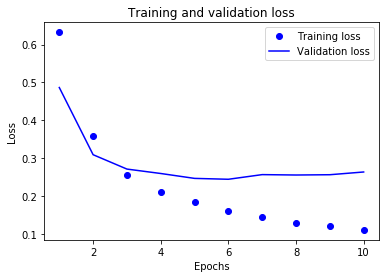

In [391]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

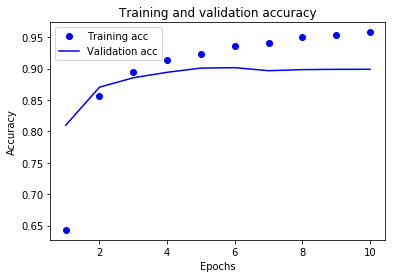

In [392]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Custom test

In [393]:
stroka  = "Две веселые овечки Разрезвились возле речки. Прыг-скок, прыг-скок! (Весело прыгаем) Скачут белые овечки Рано утром возле речки. Прыг-скок, прыг-скок! Вверх до неба, вниз до травки. Вверх до неба, вниз до травки. (Встаем на ножки, тянемся вверх. Приседаем, руки опускаем вниз) А потом кружились(Кружимся) И в речку свалились. (Падаем)Две веселые овечки Разрезвились возле речки. Прыг-скок, прыг-скок! (Весело прыгаем) Скачут белые овечки Рано утром возле речки. Прыг-скок, прыг-скок! Вверх до неба, вниз до травки. Вверх до неба, вниз до травки. (Встаем на ножки, тянемся вверх. Приседаем, руки опускаем вниз) А потом кружились(Кружимся) И в речку свалились. (Падаем)Две веселые овечки Разрезвились возле речки. Прыг-скок, прыг-скок! (Весело прыгаем) Скачут белые овечки Рано утром возле речки. Прыг-скок, прыг-скок! Вверх до неба, вниз до травки. Вверх до неба, вниз до травки. (Встаем на ножки, тянемся вверх. Приседаем, руки опускаем вниз) А потом кружились(Кружимся) И в речку свалились. (Падаем)Две веселые овечки Разрезвились возле речки. Прыг-скок, прыг-скок! (Весело прыгаем) Скачут белые овечки Рано утром возле речки. Прыг-скок, прыг-скок! Вверх до неба, вниз до травки. Вверх до неба, вниз до травки. (Встаем на ножки, тянемся вверх. Приседаем, руки опускаем вниз) А потом кружились(Кружимся) И в речку свалились. (Падаем)Две веселые овечки Разрезвились возле речки. Прыг-скок, прыг-скок! (Весело прыгаем) Скачут белые овечки Рано утром возле речки. Прыг-скок, прыг-скок! Вверх до неба, вниз до травки. Вверх до неба, вниз до травки. (Встаем на ножки, тянемся вверх. Приседаем, руки опускаем вниз) А потом кружились(Кружимся) И в речку свалились. (Падаем)Две веселые овечки Разрезвились возле речки. Прыг-скок, прыг-скок! (Весело прыгаем) Скачут белые овечки Рано утром возле речки. Прыг-скок, прыг-скок! Вверх до неба, вниз до травки. Вверх до неба, вниз до травки. (Встаем на ножки, тянемся вверх. Приседаем, руки опускаем вниз) А потом кружились(Кружимся) И в речку свалились. (Падаем)Две веселые овечки Разрезвились возле речки. Прыг-скок, прыг-скок! (Весело прыгаем) Скачут белые овечки Рано утром возле речки. Прыг-скок, прыг-скок! Вверх до неба, вниз до травки. Вверх до неба, вниз до травки. (Встаем на ножки, тянемся вверх. Приседаем, руки опускаем вниз) А потом кружились(Кружимся) И в речку свалились. (Падаем)"

In [394]:
def stringOfWordsToTestList(tale):
    
    # splitting string to list of words
    listOfWords = re.findall(r'\w+', tale)
    
    # changing each word to it's number
    listOfNumbers = list(map(lambda y: dictionary.get(y, 0), listOfWords))
    
    # splitting list of numbers to list of lists where each list contains 128 numbers
    listOfListsOfNumbers = [listOfNumbers[x:x+128] for x in range(0, len(listOfNumbers), 128)]
    
    # preprocessing each list
    listOfListsOfNumbers = keras.preprocessing.sequence.pad_sequences(listOfListsOfNumbers,
                                                                      value=0,
                                                                      padding='post',
                                                                      maxlen=128)
    return listOfListsOfNumbers

In [395]:
def prepareSingleString(tale):
    
     # splitting string to list of words
    listOfWords = re.findall(r'\w+', tale)
    
    # changing each word to it's number
    listOfNumbers = list(map(lambda y: dictionary.get(y, 0), listOfWords))
    
    # splitting list of numbers to list of lists where each list contains 128 numbers
    listOfListOfNumbers = [listOfNumbers]
    
    # preprocessing each list
    listOfListOfNumbers = keras.preprocessing.sequence.pad_sequences(listOfListOfNumbers,
                                                                      value=0,
                                                                      padding='post',
                                                                      maxlen=128)
    return listOfListOfNumbers

In [396]:
np.average(model.predict(stringOfWordsToTestList(stroka)))

0.00019558783

## Saving model 

In [397]:
model.save('scripts/files/full_model.h5')

In [398]:
new_model = keras.models.load_model('scripts/files/full_model.h5')
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 16)          159968    
_________________________________________________________________
global_average_pooling1d_10  (None, 16)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 17        
Total params: 160,257
Trainable params: 160,257
Non-trainable params: 0
_________________________________________________________________


In [399]:
results = new_model.evaluate(test_data, test_labels)

7016/7016 [==============================] - 1s 108us/sample - loss: 0.2606 - acc: 0.8952


In [400]:
np.average(new_model.predict(stringOfWordsToTestList("лол кек чебурек фыв и")))

0.666189

# Comparing models 

In [401]:
def AccRecPrec(predictions):
    #define the method
    x = tf.placeholder(tf.int32, )
    y = tf.placeholder(tf.int32, )
    acc, acc_op = tf.metrics.accuracy(labels=x, predictions=y)
    rec, rec_op = tf.metrics.recall(labels=x, predictions=y)
    pre, pre_op = tf.metrics.precision(labels=x, predictions=y)
    f1,  f1_op  = tf.contrib.metrics.f1_score(labels=x, predictions=y)

    def f(x):
        if (x>0.5):
            return 1
        else:
            return 0
        
    #predict the class using your classifier
    predictions = np.array(list(map(f, predictions)))

    #run the session to compare the label with the prediction
    sess=tf.Session()
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    v = sess.run(acc_op, feed_dict={x: test_labels,y: predictions}) #accuracy
    r = sess.run(rec_op, feed_dict={x: test_labels,y: predictions}) #recall
    p = sess.run(pre_op, feed_dict={x: test_labels,y: predictions}) #precision
    f = sess.run(f1_op,  feed_dict={x: test_labels,y: predictions}) #f1

    print("accuracy: ", v)
    print("recall:   ", r)
    print("precision:", p)
    print("f1:       ", 2*p*r/(p+r))
    

## 1 

Stats of our model

In [402]:
predictions1 = list(model.predict(test_data))

In [403]:
AccRecPrec(predictions1)
   

accuracy:  0.8952395
recall:    0.9157536
precision: 0.9062651
f1:        0.9109846645988376


## 2 

Stats of random model

We should generate random predictions for our labels

In [258]:
predictions2 = []

In [259]:
for i in test_labels:
    predictions2.append(i)

In [260]:
random.shuffle(predictions2)

In [261]:
AccRecPrec(predictions2)

accuracy:  0.5245154
recall:    0.6066038
precision: 0.6066038
f1:        0.6066038012504578


### 3 

Rule based model

In [262]:
predictions3 = []
obscene_words_number = list(map(lambda y: dictionary.get(y, 0), obsceneWordList))

In [263]:
for i in test_data:
    category = 0
    for j in i:
        if j in obscene_words_number:
            category = 1
    predictions3.append(category)

In [211]:
len(test_labels)

7016

In [209]:
test_labels.sum()

4240

In [264]:
AccRecPrec(predictions3)

accuracy:  0.41476625
recall:    0.031603772
precision: 1.0
f1:        0.06127114264154606
